In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))


from log_processing import process_log, from_csv

In [23]:
log_file = "../../backtests/test.log"
trader_data, products_data, activities, trades = process_log(log_file)

In [24]:
sb2 = products_data["SYNTHETIC_BASKET2"]
sb2_buy_spread = sb2["buy_spread"]
sb2_sell_spread = sb2["sell_spread"]
sb2_zscore_buy = sb2["z_score_buy"]
sb2_zscore_sell = sb2["z_score_sell"]

new_time = sb2["timestamp"]

In [25]:
crois = activities[activities["product"] == "CROISSANTS"].reset_index(drop=True)
jams = activities[activities["product"] == "JAMS"].reset_index(drop=True)
djem = activities[activities["product"] == "DJEMBES"].reset_index(drop=True)
pb1 = activities[activities["product"] == "PICNIC_BASKET1"].reset_index(drop=True)
pb2 = activities[activities["product"] == "PICNIC_BASKET2"].reset_index(drop=True)

cro_ask = crois["ask_price_1"]
cro_bid = crois["bid_price_1"]

jams_ask = jams["ask_price_1"]
jams_bid = jams["bid_price_1"]

dje_ask = djem["ask_price_1"]
dje_bid = djem["bid_price_1"]

pb1_ask = pb1["ask_price_1"]
pb1_bid = pb1["bid_price_1"]

pb2_ask = pb2["ask_price_1"]
pb2_bid = pb2["bid_price_1"]

syn_bid = 4 * cro_bid + 2 * jams_bid 
syn_ask = 4 * cro_ask + 2 * jams_ask

spread_buy = pb2_ask - syn_bid
spread_sell = pb2_bid - syn_ask

z_score_buy = (spread_buy - spread_buy.mean()) / spread_buy.std()
z_score_sell = (spread_sell - spread_sell.mean()) / spread_sell.std()

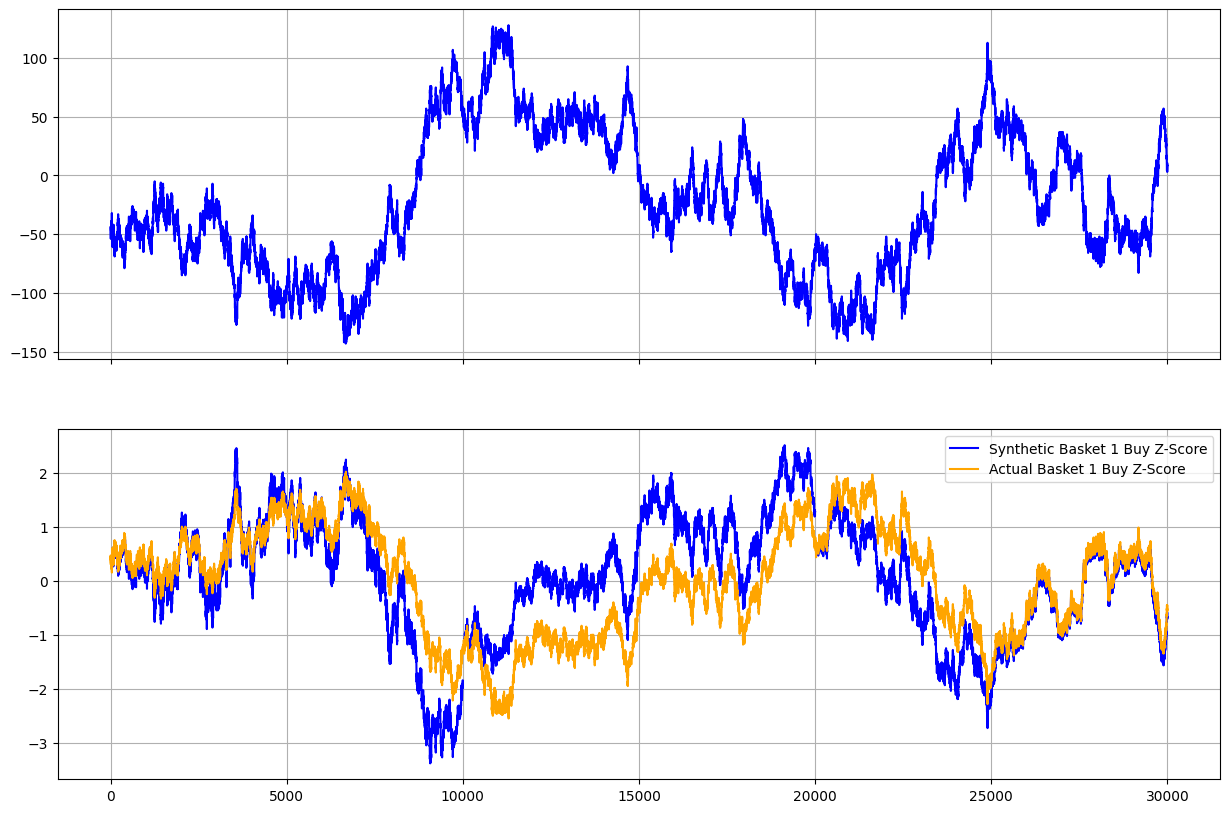

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

axs[0].plot(syn_ask - pb2_bid, label="Spread", color="blue")
axs[0].grid()

axs[1].plot(sb2_zscore_buy, label="Synthetic Basket 1 Buy Z-Score", color="blue")
axs[1].plot(z_score_buy, label="Actual Basket 1 Buy Z-Score", color="orange")
axs[1].grid()
axs[1].legend()